# Optical flow of Goes-16 images

Importing necessary libraries

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cartopy.crs as ccrs
import numpy as np
import os, cv2, math, statistics, datetime
from PIL import Image
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid

Setting location names and coordinates

In [9]:
# List containing the location name, Latitude and Longitude of the surface stations
locations = [['Brasilia', -15.60083, -47.71306],
             ['Cachoeira Paulista', -22.6896, -45.0062],
             ['Petrolina', -9.0689, -40.3197],
             ['Sao Martinho da Serra', -29.4428, -53.8231]]

## Cropping NetCDF files

In [9]:
# Setting the source files path, this is where all files with the .nc extension are located
path = r"C:\Users\rodri\Documents\Unifesp\Mestrado\Goes\Arquivos inteiros"
directory = os.fsencode(path)
os.chdir(path)

# Looping through locations
for location in locations:
    
    # Looping through every .nc file in the directory
    for file in os.listdir(directory):
        
        # Opening the dataset with xarray library
        ncfile = file.decode('utf-8')
        ds = xr.open_dataset(ncfile)
        
        # Extracting the date from the file
        date = str(ds.attrs['date_created'])
    
        # Selecting the variables
        lon = ds['lon'].values
        lat = ds['lat'].values

        # Setting the value of k, this is the size of our box around the location
        k = 2.0
        
        # Setting the latitude and latitude
        lat_station = location[1]
        lon_station = location[2]
        lat_list = list(lat)
        lon_list = list(lon)
        
        # Finding the closest point in the dataset that matches our location latitude and longitude
        lat_start = lat_list.index(lat_list[min(range(len(lat_list)), key = lambda i: abs(lat_list[i]-(lat_station - k)))])
        lat_end = lat_list.index(lat_list[min(range(len(lat_list)), key = lambda i: abs(lat_list[i]-(lat_station + k)))])
        lon_start = lon_list.index(lon_list[min(range(len(lon_list)), key = lambda i: abs(lon_list[i]-(lon_station - k)))])
        lon_end = lon_list.index(lon_list[min(range(len(lon_list)), key = lambda i: abs(lon_list[i]-(lon_station + k)))])
        
        # Setting the new .nc file with our specified dimensions
        data = ds['CMI'][lat_start:lat_end, lon_start:lon_end]
        
        # Naming our file with the date and time
        file = date[0:4] + '_' + date[5:7] + '_' + date[8:10] + '_' + date[11:13] + date[14:16]
        
        # Saving the cropped NetCDF file
        data.to_netcdf(path=fr"C:\Users\rodri\Documents\Unifesp\Mestrado\Goes\{location[0]}\{file}.nc")

## Plotting NetCDF Goes-16 images

In [13]:
for location in locations:
    
    # Setting the source files path, this is where all cropped files with the .nc extension are located
    path = rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Goes\{location[0]}"
    directory = os.fsencode(path)
    os.chdir(path)
    
    # Looping through every cropped .nc file in the directory
    for file in os.listdir(directory):
        
        ncfile = file.decode("utf-8")
        ds = xr.open_dataset(ncfile)

        # Plotting the image
        fig=plt.figure(figsize=(10,10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        mapa=ds['CMI'].plot(ax=ax,transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False, cmap='gray', vmax=0.8, vmin=0)
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(mapa, cax=cax).remove()
        gl=ax.grid(True)

        # Changing the directory to where we wish to save the image
        os.chdir(rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Input")
        plt.savefig(file.decode("utf-8")[0:-3] + '.png')
        os.chdir(rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Goes\{location[0]}")
        plt.close()

## Cropping the border out of the .png file

In [41]:
for location in locations:
    
    path = rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Input"
    directory = os.fsencode(path)
    os.chdir(path)

    for file in os.listdir(directory):
        
        # Setting image
        img = file.decode("utf-8")

        # Opens a image in RGB mode 
        im = Image.open(img) 

        # Size of the image in pixels (size of orginal image) 
        # (This is not mandatory) 
        width, height = im.size 

        # Setting the points for cropped image 
        left = 21
        top = 21
        right = 517
        bottom = 516
        
        # Cropped image of above dimension 
        # (It will not change orginal image) 
        im1 = im.crop((left, top, right, bottom)) 

        # Overwriting the file (IT WILL CHANGE THE ORIGINAL IMAGE)
        im1.save(file.decode('utf-8'))

## Calculating the optical flow

In [37]:
"""
@author: Lucas R. De Pretto
"""
for location in locations:
    # Directory path to be used as input frames
    frame_folder = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Input'

    # Direcotry path where the forecasted frames will be saved
    output_folder = rf'C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Output'

    # Sequential images to be used for the optical flow
    frames = ['2019_01_01_1641.png', '2019_01_01_1656.png']

    # Forecast window (how many forecasted frames will be generated)
    forecast_window = 7

    # Algorithm split into 2 loops, the first one goes through all available frames
    # The second loop creates forecast images from the previous generated forecast

    # Loop 1: available frames
    for i in range (1,len(frames)):

        # Setting file path
        nome_frame1 = os.path.join(frame_folder, frames[i-1])
        nome_frame2 = os.path.join(frame_folder,frames[i])
        nome_saida = os.path.join(output_folder, 'FLOWMAP_FRAME{0}-{1}.png'.format(int(i-1), int(i)))
        nome_saida2 = os.path.join(output_folder, 'FORECAST_FRAME{0}.png'.format(int(i+1)))

        # Reading the images
        frame1 = cv2.imread(nome_frame1)
        prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY) 
        frame2 = cv2.imread(nome_frame2)
        nxt = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY) 

        # Preparing the flowmap array
        hsv_mask = np.zeros_like(frame1) 
        hsv_mask[..., 1] = 255

        # Applying Farnerback Optical Flow
        flow = cv2.calcOpticalFlowFarneback(prvs, nxt, None, 0.5, 31, 25, 3, 5, 1.2, 0) 

        # Obtaining the magnitude and angle of the displacement vector
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees = True) 

        # Creating mask to be used on future frames
        mag_i = mag.astype(int)
        mag_i = np.where(mag_i == 0, 1, 0)

        # Splitting the vectors u and v from the optical flow
        v = flow[...,1]
        u = flow[...,0]

        ub = u
        vb = v

        # Saving the flowmap in 4 directions
        down_mask = np.where((ang > 45) & (ang <=135), 90, 0)
        up_mask = np.where((ang > 225) & (ang <=315), 270, 0)
        left_mask = np.where((ang > 135) & (ang <=225), 180, 0)
        right_mask = np.where((ang > 315) | (ang <=45), 0, 0)
        fin_mask = down_mask + up_mask + left_mask + right_mask

        # Saturating the top 1% of the magnitude to reduce the range of the values
        cutoff = np.percentile(mag, 99)
        mag[mag>cutoff] = cutoff

        # Filling the flowmap array
        hsv_mask[..., 0] = fin_mask    
        hsv_mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX) 

        # Converting the flowmap array to RGB and saving
        rgb_representation = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR) 
        #cv2.imwrite(nome_saida, rgb_representation)


        # Preparing the forecast frame. The multiplication by the magnitude mask allows the filling of the stationary areas,
        # this avoids the overwriting of pixels
        next_frame = frame2[:,:,0] * mag_i

        # Conducting the forecast of the next frame
        # It is necessary to go through each pixel, applying the dispplacement vector
        # Pixels moving outside of the frame and stationary pixels are ignored
        for i in range(frame2.shape[0]):
            for j in range(frame2.shape[1]):

                if (int(ub[i,j]==0) and int(vb[i,j]==0) ):
                    continue

                if ((i + int(vb[i,j])) >= next_frame.shape[0]) or ((j + int(ub[i,j])) >= next_frame.shape[1]):
                    continue

                next_frame[i + int(vb[i,j]), j + int(ub[i,j])] = frame2[i,j,0]


        # Applying a selective median filter, this removes deformations
        next_frame3 = cv2.medianBlur(next_frame.astype(np.float32), 5)    
        next_frame2 = np.where(next_frame == 0, next_frame3, next_frame)

        # Saving the forecasted frame and preparing the array for the next iteration
        cv2.imwrite(nome_saida2, next_frame2.astype(np.int64))
        next_frame = np.zeros( (next_frame2.shape[0],next_frame2.shape[1], 3) ).astype(int)
        next_frame[...,0] = next_frame2.astype(int)
        next_frame[...,1] = next_frame2.astype(int)
        next_frame[...,2] = next_frame2.astype(int)

    # Second loop: additional forecasts
    # The amount of iterations is equal to the forecast range
    for i in range(forecast_window):

        # Setting file path
        j = i + len(frames)
        nome_saida = os.path.join(output_folder, 'FLOWMAP_FRAME{0}-{1}.png'.format(int(j-1), int(j)))
        nome_saida2 = os.path.join(output_folder, 'FORECAST_FRAME{0}.png'.format(int(j+1)))

        # # Reading the images
        frame1 = frame2.copy()
        frame2 = next_frame.copy()    
        prvs = frame1[...,0]
        nxt = frame2[...,0]

        # Preparing the flowmap array
        hsv_mask = np.zeros((frame1.shape)).astype(np.uint8)
        hsv_mask[..., 1] = 255

        # Applying Farnerback Optical Flow
        flow = cv2.calcOpticalFlowFarneback(prvs, nxt, None, 0.5, 31, 25, 3, 5, 1.2, 0) 

        # Obtaining the magnitude and angle of the displacement vector
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees = True) 

        # Creating mask to be used on future frames
        mag_i = mag.astype(int)
        mag_i = np.where(mag_i == 0, 1, 0)

        # Splitting the vectors u and v from the optical flow
        v = flow[...,1]
        u = flow[...,0]    

        ub = u
        vb = v

        # 4 Directions
        down_mask = np.where((ang > 45) & (ang <=135), 90, 0)
        up_mask = np.where((ang > 225) & (ang <=315), 270, 0)
        left_mask = np.where((ang > 135) & (ang <=225), 180, 0)
        right_mask = np.where((ang > 315) | (ang <=45), 0, 0)
        fin_mask = down_mask + up_mask + left_mask + right_mask

        # Saturating the top 1% of the magnitude to reduce the range of the values
        cutoff = np.percentile(mag, 99)
        mag[mag>cutoff] = cutoff

        # Filling the flowmap array
        hsv_mask[..., 0] = fin_mask    
        hsv_mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Converting the flowmap array to RGB and saving
        rgb_representation = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR) 
        #cv2.imwrite(nome_saida, rgb_representation)

        # Preparing the forecast frame. The multiplication by the magnitude mask allows the filling of the stationary areas,
        # this avoids the overwriting of pixels
        next_frame = frame2[:,:,0] * mag_i

        # Conducting the forecast of the next frame
        # It is necessary to go through each pixel, applying the dispplacement vector
        # Pixels moving outside of the frame and stationary pixels are ignored
        for i in range(frame2.shape[0]):
            for j in range(frame2.shape[1]):

                if (int(ub[i,j]==0) and int(vb[i,j]==0) ):
                    continue

                if ((i + int(vb[i,j])) >= next_frame.shape[0]) or ((j + int(ub[i,j])) >= next_frame.shape[1]):
                    continue

                next_frame[i + int(vb[i,j]), j + int(ub[i,j])] = frame2[i,j,0]

        # Applying a selective median filter, this removes deformations
        next_frame3 = cv2.medianBlur(next_frame.astype(np.float32), 5)    
        next_frame2 = np.where(next_frame == 0, next_frame3, next_frame)

        # Saving the forecasted frame and preparing the array for the next iteration
        cv2.imwrite(nome_saida2, next_frame2.astype(np.int64))
        next_frame = np.zeros( (next_frame2.shape[0],next_frame2.shape[1], 3) ).astype(int)
        next_frame[...,0] = next_frame2.astype(int)
        next_frame[...,1] = next_frame2.astype(int)
        next_frame[...,2] = next_frame2.astype(int)

## Replacing and renaming files for future plotting (optional)

The code below consists of taking the real Goes-16 and forecast images from the same timestamp, renaming the files and placing them in a folder where it will be further used for plotting (comparing real/forecast images). 

In [38]:
for location in locations:

    ## PART 1: REAL IMAGES
    # Changing directory to where the real images are located
    directory = rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Input"
    os.chdir(rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Input")

    # Creaiting a list where all file names will be stored
    files = []

    # Looping through the folder and adding the file names to the list
    for filename in os.listdir(directory):
        files.append(filename)

    # Creating variables to store the index of where our forecast begins and ends, according to our forecast window
    # set in the Optical Flow code
    start_frame = files.index(frames[1]) + 1
    end_frame = forecast_window

    # Looping through the list, starting on our first forecast and ending on the last
    for i in range(start_frame, (start_frame + end_frame + 1)):

        # Opening the file with PIL and converting from 32 bit RGB to 8 bit grayscale
        im = Image.open(files[i]).convert('L')

        # Changing directory to where the image will be saved
        os.chdir(rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Sample")

        # The purpose of this condition is to rename the files so when the folder sorts itself by file name we get the following
        # Sequence: 4 real images, 4 forecast images, 4 real images, 4 forecast images (the plot will be a 4x4 grid)
        if i - files.index(frames[1]) < 5:
            file_prefix = str(i - files.index(frames[1])) + "_"
            im.save(f"{file_prefix + files[i]}")
        else:
            file_prefix = str(i - files.index(frames[1]) + 4) + "_"
            im.save(f"{file_prefix + files[i]}")

        # Changing the directory back to the real images location
        os.chdir(rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Input")


    ## PART 2: FORECAST IMAGES
    # Changing directory to where the forecast images are located
    directory = rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Output"
    os.chdir(rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Output")

    # Looping through the folder
    for filename in os.listdir(directory):

        # Opening the file with PIL
        im = Image.open(filename).convert('L')

        # Changing directory to where the image will be saved
        os.chdir(rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Sample")

        # Renaming the files so they are in the proper order when plotting
        if int(filename[-5]) < 6:
            file_prefix = str(int(filename[-5]) + 3) + "_"
            im.save(f"{file_prefix + filename}")

        else:
            file_prefix = str(int(filename[-5]) + 7) + "_"
            im.save(f"{file_prefix + filename}")

        # Changing directory back to where the forecast images are located
        os.chdir(rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Output")

## Cropping the forecast and real images

We previously set our area of interest sized as a 4x4 square (2 degrees to the right/left and 2 degrees upwards/downwards from our surface station), this was done to reduce the border deformation when applying the optical flow. Now we must set the square to the size of 2x2, this will be our final setting over our area of interest.

In [39]:
for location in locations:
    directory = rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Sample"
    os.chdir(rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Sample")

    for filename in os.listdir(directory):
        im = Image.open(filename) 

        # Changing dimensions from 4x4 to 2x2
        left = 125
        top = 121
        right = 375
        bottom = 371

        # Cropped image of above dimension 
        # (It will not change orginal image) 
        im = im.crop((left, top, right, bottom)) 

        # Saving the new image (IT WILL CHANGE THE ORIGINAL IMAGE)
        im.save(filename)

## Plotting a grid of real/forecast images

In [55]:
for location in locations:
    path1 = rf"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\{location[0]}\Sample"
    path2 = r"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras"
    directory = path1
    os.chdir(path1)

    # List to store files
    imgs_name = []
    imgs = []

    # List for plot titles
    titles = ['Real t+15', 'Real t+30', 'Real t+45', 'Real t+60',
             'Forecast t+15', 'Forecast t+30', 'Forecast t+45', 'Forecast t+60',
             'Real t+75', 'Real t+90', 'Real t+105', 'Real t+120',
             'Forecast t+75', 'Forecast t+90', 'Forecast t+105', 'Forecast t+120',]

    # Looping through files in folder, adding to list
    for filename in os.listdir(directory):
        imgs_name.append(filename)

    # Sorting the file in the proper order
    for i in range(7):
        imgs_name.append(imgs_name[i])

    del imgs_name[0:7]

    # PLOTTING
    for name in imgs_name:
        im = Image.open(name)
        imgs.append(im)
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=(4, 4),  
                     axes_pad=0.25,
                     share_all = True 
                     )

    # Deleting axis ticks
    grid[0].get_yaxis().set_ticks([])
    grid[0].get_xaxis().set_ticks([])

    i = 0
    for ax, im in zip(grid, imgs):
        # Iterating over the grid returns the Axes.
        ax.set_title(f"{titles[i]}")
        ax.imshow(im, cmap='gray')
        ax = plt.gca()
        ax.axes.yaxis.set_visible(False)
        i += 1
    
    os.chdir(path2)
    plt.savefig(f'{location[0]}.png')
    os.chdir(path1)
    plt.close()

## Validating forecasts with the Constanza goodness of fit method

 ### Part 1: Calculating the fit for a given forecast scene

In [24]:
# File path
os.chdir(r"C:\Users\rodri\Documents\Unifesp\Mestrado\Figuras\Goes\Sao Martinho da Serra\Sample")

# Real GOES-16 image file
real = mpimg.imread("9_2019_01_01_1811.png")

# Forecast image file
forecast = mpimg.imread("13_FORECAST_FRAME6.png")

# CATEGORIZING ARRAYS
# Scene 1: observed GOES-16 image
# Category 1: clear sky
clear = (real <= 0.26) * 1

# Category 2: partial overcast
partial = ((real > 0.26) & (real < 0.75)) * 2

# Category 3: overcast
overcast = (real >= 0.75) * 3

# Joining categories into scene 1
real_cat = clear + partial + overcast

# Scene 2: forecast with optical flow (Farnerbäck)
# Category 1: clear sky
clear = (forecast <= 0.26) * 1

# Category 2: partial overcast
partial = ((forecast > 0.26) & (forecast < 0.75)) * 2

# Category 3: overcast
overcast = (forecast >= 0.75) * 3

# Joining categories into scene 2
forecast_cat = clear + partial + overcast

# CALCULATING THE GOODNESS OF FIT
scene_1 = real_cat
scene_2 = forecast_cat

# Storing all values from the window w x w contained in the scene
t = []

# Storing the mean values of contained in the scene, of each sampling window w x w
fw = []

print("Initiating goodness of fit calculations, this might take a while :)")

# Starting the loop, beginning at windows with dimensions 1x1, ending with dimensions of the scene
for w in range(len(scene_1)):   
    
    # Creating sub-arrays by sliding through all windows with dimensions w x w contained in the scene
    windows_s1 = np.lib.stride_tricks.sliding_window_view(scene_1, (w+1,w+1))
    windows_s2 = np.lib.stride_tricks.sliding_window_view(scene_2, (w+1,w+1))
    
    # Associating each sub-array of both scenes by storing them in a tuple
    windows_s = tuple(zip(windows_s1, windows_s2))
    
    # Looping through all sub-arrays
    for row in range(len(windows_s)):
            
        for column in range(len(windows_s[0][0])):
                
            w1 = windows_s[row][0][column]
            w2 = windows_s[row][1][column]
            
            # Couting how many values of each category are in each sub-array
            s1 = np.array([np.count_nonzero(w1 == 1), np.count_nonzero(w1 == 2), 
                                np.count_nonzero(w1 == 3), np.count_nonzero(w1 == 4)])
            s2 = np.array([np.count_nonzero(w2 == 1), np.count_nonzero(w2 == 2), 
                                np.count_nonzero(w2 == 3), np.count_nonzero(w2 == 4)])
            
            # Storing values in t obtained from the Constanza equation
            t.append(1-(sum(abs(s1-s2)/(2*((w+1)**2)))))
    
    # Obtaining every fw value by calculating the mean
    fw.append(sum(t)/len(t))
    
    # Clearing t for further use
    t = []

# CALCULATING THE FINAL FIT VALUE, FT
# Defining k, the higher the value, the more weight is given to smaller windows
k = 0.6

# Temporary lists to store values for further use
ft1 = []
ft2 = []

for i in range(len(fw)):
    ft1.append(fw[i] * math.exp(-k * ((i + 1) - 1)))
    ft2.append(math.exp(-k * ((i + 1) - 1)))

# Final fit value, ft
ft = sum(ft1)/sum(ft2)
ft_plot = ft


# Saving values for future plotting
x = [i for i in range(1,len(scene_1) + 1)]
y = fw

Calculating window 1
Calculating window 2
Calculating window 3
Calculating window 4
Calculating window 5
Calculating window 6
Calculating window 7
Calculating window 8
Calculating window 9
Calculating window 10
Calculating window 11
Calculating window 12
Calculating window 13
Calculating window 14
Calculating window 15
Calculating window 16
Calculating window 17
Calculating window 18
Calculating window 19
Calculating window 20
Calculating window 21
Calculating window 22
Calculating window 23
Calculating window 24
Calculating window 25
Calculating window 26
Calculating window 27
Calculating window 28
Calculating window 29
Calculating window 30
Calculating window 31
Calculating window 32
Calculating window 33
Calculating window 34
Calculating window 35
Calculating window 36
Calculating window 37
Calculating window 38
Calculating window 39
Calculating window 40
Calculating window 41
Calculating window 42
Calculating window 43
Calculating window 44
Calculating window 45
Calculating window 

### Part 2: Calculating the fit for random scenes in order to obtain the value of z (statistical significance)

In [27]:
# Calculating runtime
begin_time = datetime.datetime.now()

# CALCULATING Z
fts = []

# Creating random scenes by shuffling the original
for random_scene in range(0, 5):
    
    print(f"Calculating fit for random scene {random_scene + 1}")
    
    scene_2 = forecast_cat
    scene_2 = np.random.permutation(scene_2)

    t = []
    fw = []
    
    # Starting the loop, beginning at windows with dimensions 1x1, ending with dimensions of the scene
    for w in range(len(scene_1)):
    
        # Creating sub-arrays by sliding through all windows with dimensions w x w contained in the scene
        windows_s1 = np.lib.stride_tricks.sliding_window_view(scene_1, (w+1,w+1))
        windows_s2 = np.lib.stride_tricks.sliding_window_view(scene_2, (w+1,w+1))
        
        # Associating each sub-array of both scenes by storing them in a tuple
        windows_s = tuple(zip(windows_s1, windows_s2))
        
        # Looping through all sub-arrays
        for row in range(len(windows_s)):
                
            for column in range(len(windows_s[0][0])):
                    
                w1 = windows_s[row][0][column]
                w2 = windows_s[row][1][column]
        
                # Couting how many values of each category are in each sub-array
                s1 = np.array([np.count_nonzero(w1 == 1), np.count_nonzero(w1 == 2), 
                                    np.count_nonzero(w1 == 3), np.count_nonzero(w1 == 4)])
                s2 = np.array([np.count_nonzero(w2 == 1), np.count_nonzero(w2 == 2), 
                                    np.count_nonzero(w2 == 3), np.count_nonzero(w2 == 4)])
                
                # Storing values in t obtained from the Constanza equation
                t.append(1-(sum(abs(s1-s2)/(2*((w+1)**2)))))
        
        # Obtaining every fw value by calculating the mean
        fw.append(sum(t)/len(t))
        t = []
    
    # CALCULATING THE FINAL FIT VALUE, FT
    # Defining k, the higher the value, the more weight is given to smaller windows
    k = 0.6
    
    ft1 = []
    ft2 = []
    
    for i in range(len(fw)):
        ft1.append(fw[i] * math.exp(-k * ((i + 1) - 1)))
        ft2.append(math.exp(-k * ((i + 1) - 1)))
    
    # Final fit value, ft
    ft = sum(ft1)/sum(ft2)
    fts.append(ft)
    print(fts)

z = (ft/statistics.mean(fts))/statistics.stdev(fts)
print(datetime.datetime.now() - begin_time)

Calculating random scene 1
[0.811072, 0.8269866615054596, 0.8398333622385876, 0.8498643642741235, 0.8574016788945473, 0.8633250034707098, 0.86802908478638, 0.8719784098799302, 0.8753247476013171, 0.8781601556447101, 0.8806567091368555, 0.8829051244044116, 0.8850236230935032, 0.88706285804402, 0.8888999010501685, 0.8905708182435491, 0.8921973695951966, 0.8937431110000498, 0.8952108400498958, 0.8966375723843089, 0.8979633416062632, 0.8991956486005213, 0.9004142469894242, 0.901594955429685, 0.9026932414440358, 0.9038019431660834, 0.9048832608532777, 0.9058716611380395, 0.9068154666862271, 0.9077331203974551, 0.9086025231980767, 0.9094328839447676, 0.9102510981064145, 0.9110124860374187, 0.9117538177822772, 0.9124386221447786, 0.9130959887470508, 0.9137258689273979, 0.9143332346789065, 0.9149196727387052, 0.9154865301266353, 0.9160304705507255, 0.9165723525990267, 0.9170984033109068, 0.917626822788478, 0.9181354153898229, 0.9186138057775969, 0.9190710345771296, 0.9194989335758967, 0.919910

[0.81288, 0.8271156916823922, 0.8398640738815463, 0.8499729548099461, 0.8575702293605416, 0.863382849738477, 0.8680928431572238, 0.8720935155548781, 0.8755319705107604, 0.8784127339405661, 0.880990300734634, 0.883329297067115, 0.8854044924618087, 0.8873180100434191, 0.8890756966389871, 0.8906337709370756, 0.8920644742667008, 0.8933863099837951, 0.8945922238398051, 0.8957496111392412, 0.8968577601172386, 0.8979638037929345, 0.8990294599879569, 0.9000799307186446, 0.9010960294462483, 0.9020718533129208, 0.9030145028047911, 0.9039781072597043, 0.904929216583569, 0.905868725956528, 0.9067801919487617, 0.9076538505895415, 0.9085148529467575, 0.9093548173997602, 0.9101742497411032, 0.9109523165675313, 0.9116900809708331, 0.9124022351894173, 0.913131198231297, 0.9138207250510941, 0.9144934515547549, 0.9151346359228213, 0.9157808419751753, 0.9164219938013705, 0.9170473474071142, 0.9176506917634771, 0.9182462207226397, 0.9188227659276216, 0.919385389081381, 0.9199193980346958, 0.920440503652436

[0.81088, 0.8252003999935484, 0.8382508093422876, 0.8485766444295104, 0.8563123801967006, 0.862523948354797, 0.8674984506031052, 0.8715388914291521, 0.8748601298063712, 0.8778206298101254, 0.8804843893480687, 0.8828862803910177, 0.8850245632537497, 0.8868852780658192, 0.8885913211402043, 0.8901326957899502, 0.8915572855330823, 0.892952133858768, 0.8942943410923854, 0.895610089765945, 0.8968566027544616, 0.8980548151633438, 0.8991989173926109, 0.9003079576549362, 0.9013405278407985, 0.9023948571846572, 0.9034076866987347, 0.904421941412237, 0.905405670799142, 0.9063355923642997, 0.9072336409215273, 0.9080982424196222, 0.9089406781003742, 0.9097498214563509, 0.9105379013745721, 0.9112908045056216, 0.9119833751880508, 0.912638707931963, 0.9132812278744443, 0.913890720109627, 0.9144928445302336, 0.9150762737121007, 0.9156431461032711, 0.9161990072190442, 0.9167453676065945, 0.9172860582356377, 0.9178120957238785, 0.9183107250034451, 0.9187876269245605, 0.9192528996806917, 0.919708054594382

### Part 3: Plotting the fit and z values

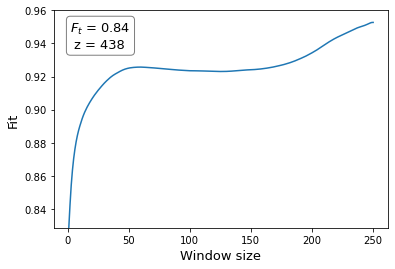

In [40]:
fig, ax = plt.subplots()
textstr = f'$F_t$ = {round(ft_plot, 2)}\n z = {round(z)}'

ax.plot(x, y)
# text box properties
props = dict(boxstyle='round', facecolor='none', alpha=0.5)

# text box location
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=13,
        verticalalignment='top', bbox=props)

plt.ylim(min(y), 0.96)
plt.ylabel('Fit', fontsize=13)
plt.xlabel('Window size', fontsize=13)
plt.show()